# Bussiness Undertsanding

## Project Domain

**Healthcare / Medical Diagnostics**

Fokus pada pemanfaatan data pasien untuk mendeteksi risiko kanker serviks secara dini menggunakan pendekatan Machine Learning.

## Problem Statements

Cervical cancer merupakan salah satu penyebab utama kematian akibat kanker pada wanita, terutama di negara berkembang, karena sering terlambat terdeteksi. Meskipun banyak faktor risiko telah diketahui (misalnya: HPV, kebiasaan merokok, penggunaan kontrasepsi hormonal), proses diagnosis masih bergantung pada tes medis yang memakan waktu dan biaya.

Namun, **banyak pasien tidak rutin menjalani tes seperti Biopsi, Hinselmann, atau Sitologi** karena akses terbatas atau kesadaran yang rendah. Hal ini menyebabkan keterlambatan dalam deteksi dini dan pengobatan.

## Goals

- Mengembangkan model klasifikasi berbasis machine learning yang mampu memprediksi risiko kanker serviks berdasarkan data faktor risiko pasien.

- Memberikan alat bantu pendukung keputusan bagi tenaga medis untuk menyaring pasien berisiko tinggi.

- Meningkatkan deteksi dini dan menurunkan beban pengujian medis yang mahal bagi pasien dengan risiko rendah.

- Mengintegrasikan model prediksi kanker serviks ke dalam aplikasi mobile berbasis Android Studio untuk memberikan kemudahan akses bagi tenaga medis dan pasien dalam melakukan simulasi risiko secara langsung.

- Menyediakan antarmuka pengguna (user interface) yang sederhana, informatif, dan mudah digunakan pada perangkat Android, sehingga dapat meningkatkan adopsi aplikasi di lingkungan klinis dan non-klinis.

## Solution Statements

- Menggunakan dataset “Cervical Cancer Risk Classification” dari Kaggle yang berisi data faktor risiko dari pasien wanita.

- Melakukan preprocessing data: penanganan missing value, encoding, normalisasi, dan penyeimbangan kelas.

- Membangun dan melatih model Artificial Neural Network (ANN) untuk klasifikasi biner (High Risk vs Low Risk).

# Data Understanding

## Import Dataset dari Kaggle

In [84]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yogidwiyanto","key":"ef7cbc628c0770609b61e290d5f08a28"}'}

In [85]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [86]:
!kaggle datasets download -d loveall/cervical-cancer-risk-classification

Dataset URL: https://www.kaggle.com/datasets/loveall/cervical-cancer-risk-classification
License(s): other
  0% 0.00/8.84k [00:00<?, ?B/s]
100% 8.84k/8.84k [00:00<00:00, 30.4MB/s]


In [87]:
!mkdir cervical-cancer-risk-classification
!unzip cervical-cancer-risk-classification.zip -d cervical-cancer-risk-classification
!ls cervical-cancer-risk-classification

Archive:  cervical-cancer-risk-classification.zip
  inflating: cervical-cancer-risk-classification/kag_risk_factors_cervical_cancer.csv  
kag_risk_factors_cervical_cancer.csv


## Import Library & Load Dataset

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2

import joblib
import json
import warnings

In [89]:
df = pd.read_csv('cervical-cancer-risk-classification/kag_risk_factors_cervical_cancer.csv')

In [90]:
df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0


In [93]:
# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

In [94]:
# Convert object columns to numeric where possible
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [95]:
# Check missing values
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nMissing values percentage:\n{(df.isnull().sum() / len(df) * 100).round(2)}")


Missing values:
Age                                     0
Number of sexual partners              26
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               108
Hormonal Contraceptives (years)       108
IUD                                   117
IUD (years)                           117
STDs                                  105
STDs (number)                         105
STDs:condylomatosis                   105
STDs:cervical condylomatosis          105
STDs:vaginal condylomatosis           105
STDs:vulvo-perineal condylomatosis    105
STDs:syphilis                         105
STDs:pelvic inflammatory disease      105
STDs:genital herpes                   105
STDs:molluscum contagiosum            105
STDs:AIDS                             105
STDs:HIV                              105
STDs:Hepatitis B 

## Exploratory Data Analysis

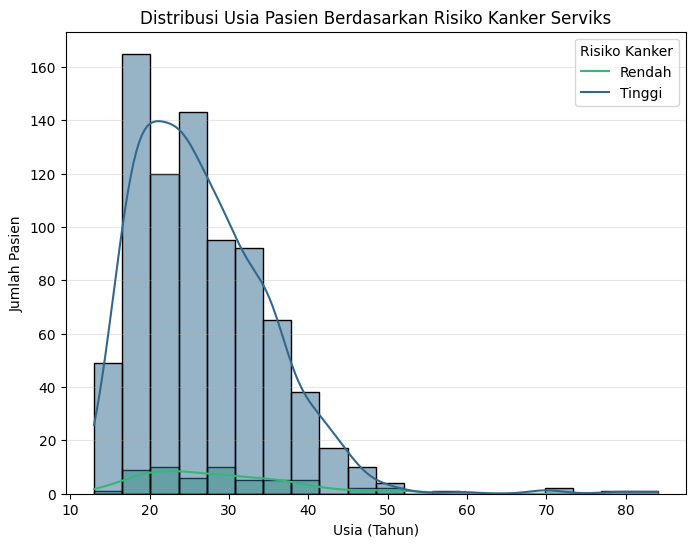

In [91]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Age', hue='Biopsy', bins=20, kde=True, palette='viridis')
plt.title('Distribusi Usia Pasien Berdasarkan Risiko Kanker Serviks')
plt.xlabel('Usia (Tahun)')
plt.ylabel('Jumlah Pasien')
plt.legend(['Rendah', 'Tinggi'], title='Risiko Kanker')
plt.grid(axis='y', alpha=0.3)
plt.show()

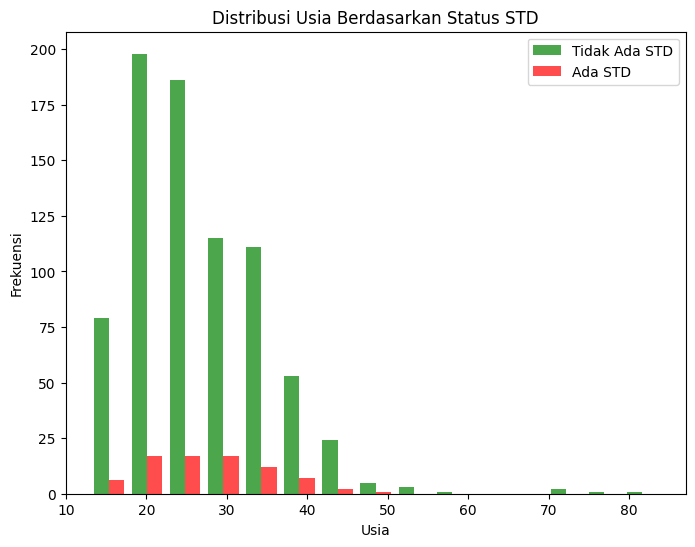

In [134]:
plt.figure(figsize=(8, 6))
no_std = df[df['STDs'].fillna(0) == 0]['Age'].dropna()
with_std = df[df['STDs'].fillna(0) == 1]['Age'].dropna()
plt.hist([no_std, with_std], bins=15, alpha=0.7, label=['Tidak Ada STD', 'Ada STD'], color=['green', 'red'])
plt.title('Distribusi Usia Berdasarkan Status STD')
plt.xlabel('Usia')
plt.ylabel('Frekuensi')
plt.legend()

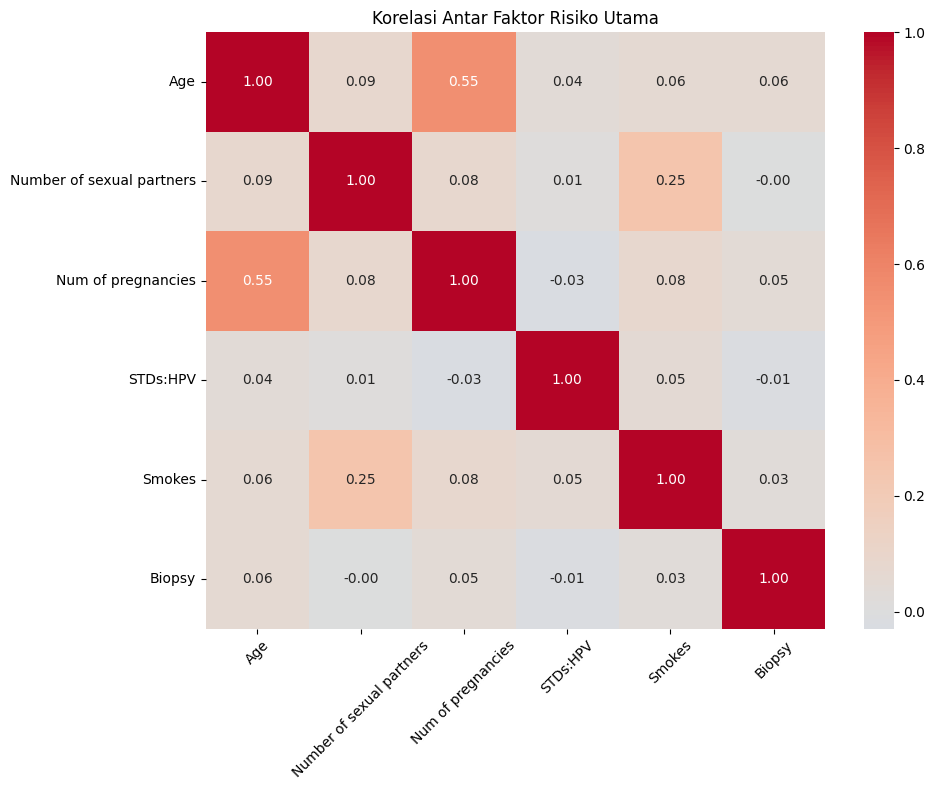

In [96]:
plt.figure(figsize=(10, 8))
corr_matrix = df[['Age', 'Number of sexual partners', 'Num of pregnancies',
                 'STDs:HPV', 'Smokes', 'Biopsy']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Korelasi Antar Faktor Risiko Utama')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-97-2233612226>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Biopsy', y='Number of sexual partners', palette='Set2')


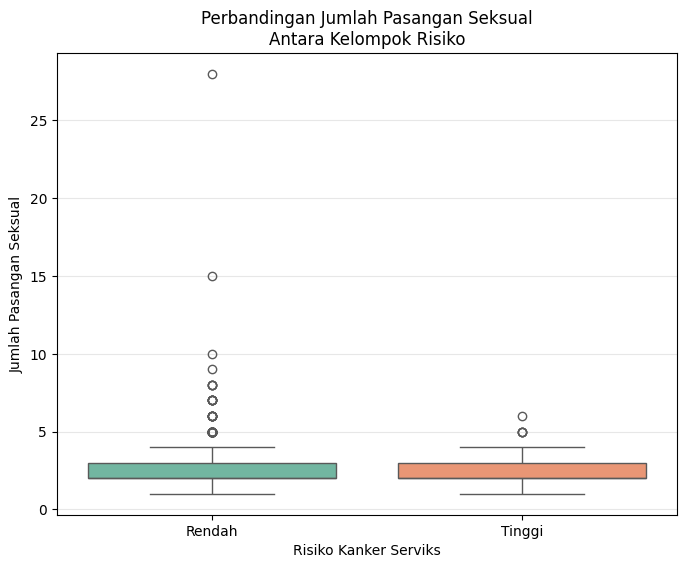

In [97]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Biopsy', y='Number of sexual partners', palette='Set2')
plt.title('Perbandingan Jumlah Pasangan Seksual\nAntara Kelompok Risiko')
plt.xlabel('Risiko Kanker Serviks')
plt.ylabel('Jumlah Pasangan Seksual')
plt.xticks([0, 1], ['Rendah', 'Tinggi'])
plt.grid(axis='y', alpha=0.3)
plt.show()

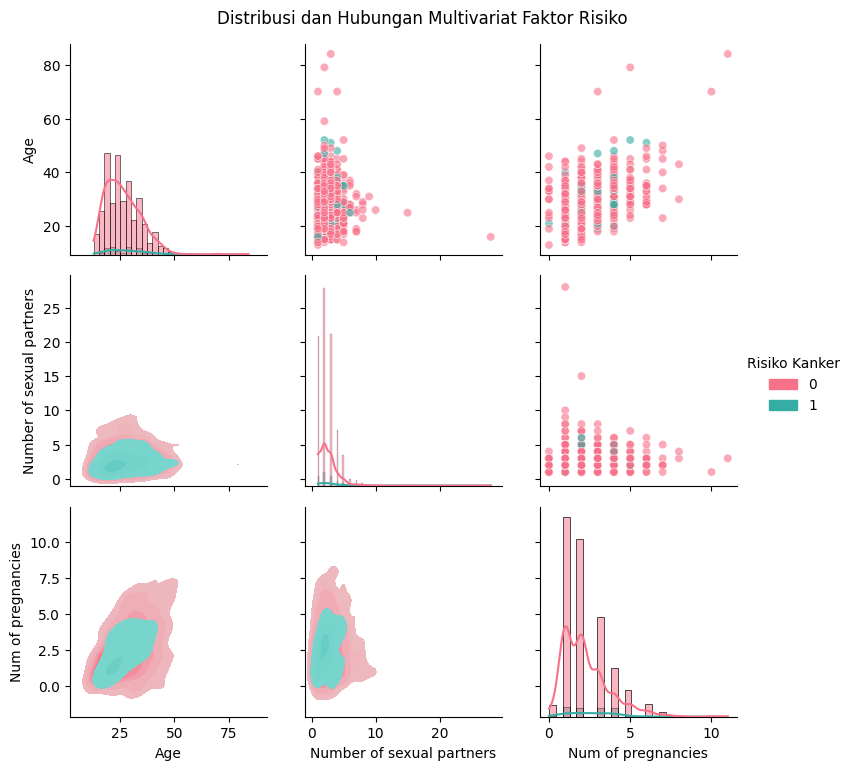

In [98]:
g = sns.PairGrid(df[['Age', 'Number of sexual partners', 'Num of pregnancies', 'Biopsy']],
                 hue='Biopsy', palette='husl')
g.map_upper(sns.scatterplot, alpha=0.6)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)
g.add_legend(title='Risiko Kanker')
plt.suptitle('Distribusi dan Hubungan Multivariat Faktor Risiko', y=1.02)
plt.show()

# Data Preparation

In [99]:
selected_features = [
    'Age',                          # Age - major risk factor
    'Number of sexual partners',     # Number of sexual partners - HPV risk
    'First sexual intercourse',     # Age at first sexual intercourse
    'Num of pregnancies',          # Number of pregnancies - hormonal changes
    'Smokes',                      # Smoking - cancer risk
    'Smokes (years)',              # Duration of smoking
    'Smokes (packs/year)',         # Smoking intensity
    'Hormonal Contraceptives',     # Hormonal contraceptives - HPV risk
    'Hormonal Contraceptives (years)', # Duration of hormonal contraceptives
    'IUD',                         # Intrauterine device
    'IUD (years)',                 # Duration of IUD use
    'STDs',                        # History of STDs
    'STDs (number)',               # Number of STDs
    'STDs:condylomatosis',         # Specific STDs
    'STDs:cervical condylomatosis',
    'STDs:vaginal condylomatosis',
    'STDs:vulvo-perineal condylomatosis',
    'STDs:syphilis',
    'STDs:pelvic inflammatory disease',
    'STDs:genital herpes',
    'STDs:molluscum contagiosum',
    'STDs:AIDS',
    'STDs:HIV',
    'STDs:Hepatitis B',
    'STDs:HPV',                    # HPV - primary cause of cervical cancer
    'STDs: Time since first diagnosis',
    'STDs: Time since last diagnosis',
    'Dx:Cancer',                   # Previous cancer diagnosis
    'Dx:CIN',                      # Cervical intraepithelial neoplasia
    'Dx:HPV',                      # HPV diagnosis
    'Dx',                          # General diagnosis
    'Hinselmann',                  # Hinselmann test result
    'Schiller',                    # Schiller test result
    'Citology',                    # Cytology test result
    'Biopsy'                       # Target variable
]

In [100]:
# Filter available columns
available_features = [col for col in selected_features if col in df.columns]
df_selected = df[available_features].copy()
print(f"\nSelected features: {len(available_features)-1}")
print(f"Available features: {available_features}")


Selected features: 34
Available features: ['Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD', 'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis', 'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease', 'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology', 'Biopsy']


In [101]:
# Handle missing values more intelligently
def handle_missing_values(df):
    df_filled = df.copy()

    # For binary features (likely 0/1), fill with mode
    binary_cols = []
    for col in df_filled.columns:
        if col != 'Biopsy':
            unique_vals = df_filled[col].dropna().unique()
            if len(unique_vals) <= 2 and all(val in [0, 1, 0.0, 1.0] for val in unique_vals):
                binary_cols.append(col)
    # Fill binary columns with mode (most frequent value)
    for col in binary_cols:
        mode_val = df_filled[col].mode()
        if len(mode_val) > 0:
            df_filled[col].fillna(mode_val[0], inplace=True)
        else:
            df_filled[col].fillna(0, inplace=True)

    # For continuous variables, use median
    for col in df_filled.select_dtypes(include=['int64', 'float64']).columns:
        if col not in binary_cols and col != 'Biopsy':
            df_filled[col].fillna(df_filled[col].median(), inplace=True)

    return df_filled

In [102]:
df_processed = handle_missing_values(df_selected)

<ipython-input-101-3364071679>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filled[col].fillna(mode_val[0], inplace=True)
<ipython-input-101-3364071679>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [103]:
# Prepare features and target
X = df_processed.drop(['Biopsy'], axis=1)
y = df_processed['Biopsy']

In [104]:
# Feature importance using Random Forest
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_temp.fit(X, y)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [105]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

In [106]:
# Fitur yang akan dipilih
print(feature_importance.head(15))

                             feature  importance
32                          Schiller    0.373927
31                        Hinselmann    0.111922
33                          Citology    0.071527
0                                Age    0.065226
2           First sexual intercourse    0.063219
8    Hormonal Contraceptives (years)    0.060572
3                 Num of pregnancies    0.044043
1          Number of sexual partners    0.036915
30                                Dx    0.023500
6                Smokes (packs/year)    0.018858
28                            Dx:CIN    0.018000
5                     Smokes (years)    0.013115
25  STDs: Time since first diagnosis    0.010944
12                     STDs (number)    0.010485
10                       IUD (years)    0.008939


In [107]:
top_features = feature_importance.head(15)['feature'].tolist()
X_selected = X[top_features]

In [108]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

In [109]:
smote = SMOTE(random_state=42, sampling_strategy='auto')
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [110]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

In [111]:
# Calculate class weights for neural network
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_balanced),
    y=y_train_balanced
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print(f"Class weights: {class_weight_dict}")

Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}


# Modelling

In [112]:
def create_improved_model(input_dim):
    model = Sequential([
        # Input layer with batch normalization
        Dense(64, input_dim=input_dim, activation='relu',
              kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(8, activation='relu'),
        Dropout(0.1),

        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    return model

In [113]:
# Create and compile model
model = create_improved_model(X_train_scaled.shape[1])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_50 (Dense)                │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,225 (16.50 KB)

 Trainable params: 4,001 (15.63 KB)

 Non-trainable params: 224 (896.00 B)

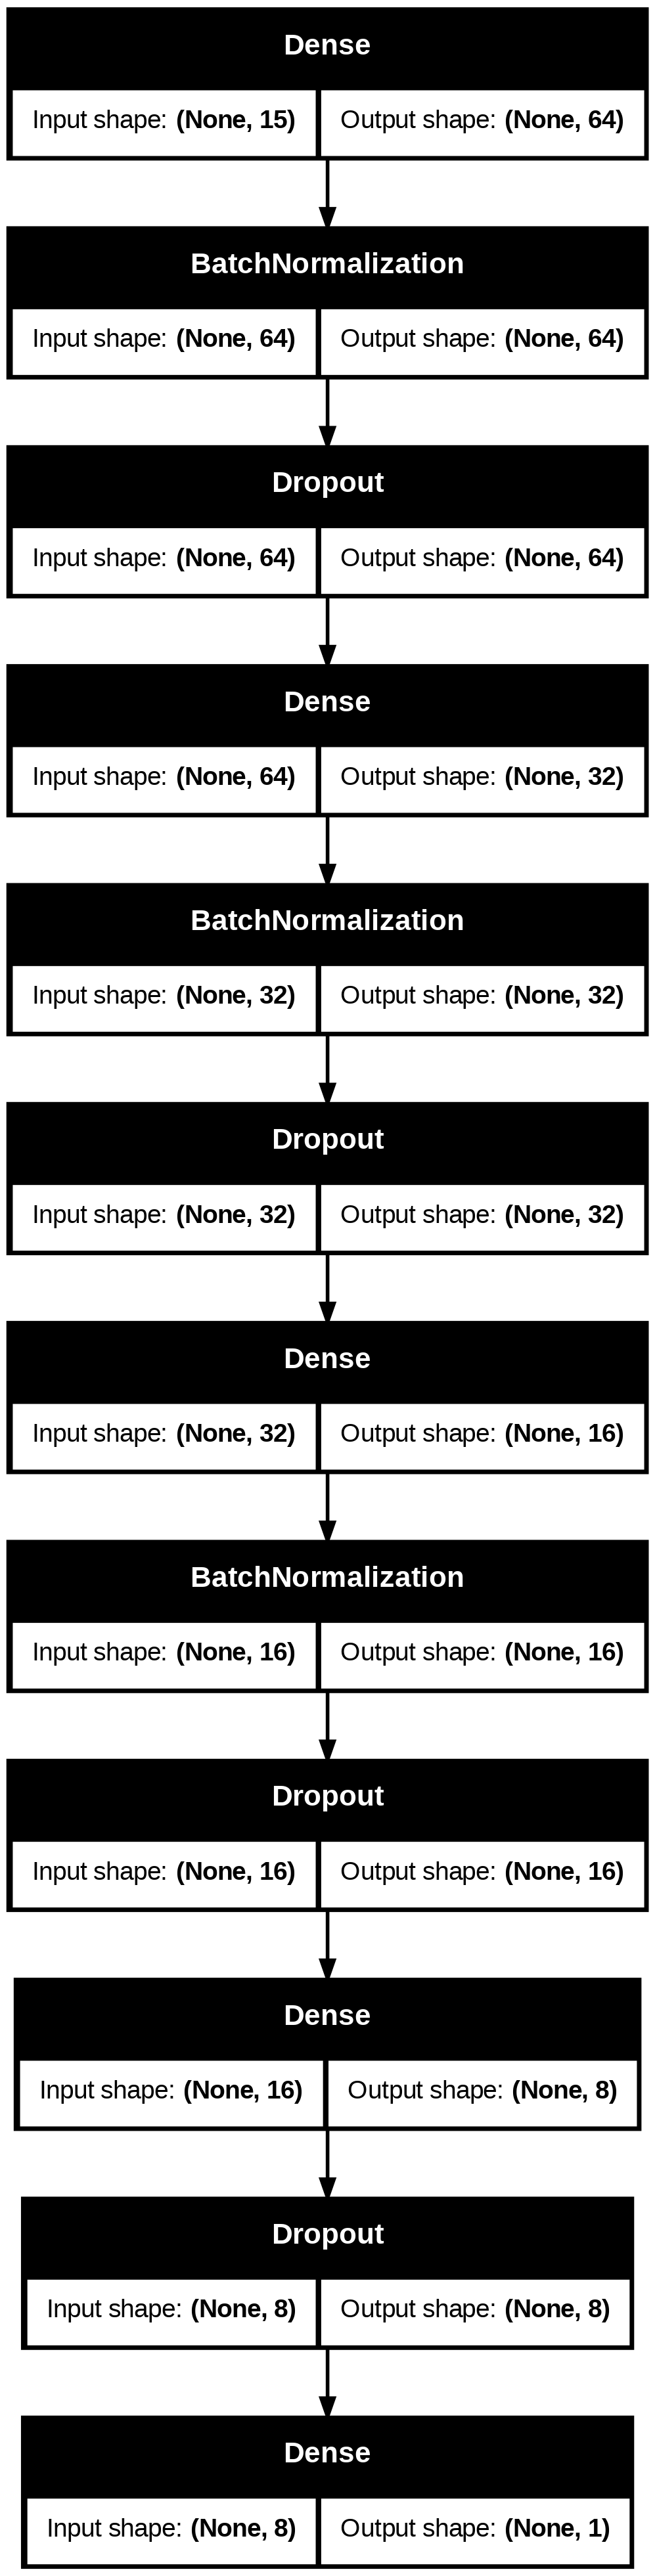

In [116]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes = True)

In [114]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=0.0001,
        verbose=1
    )
]

In [115]:
history = model.fit(
    X_train_scaled, y_train_balanced,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.5071 - loss: 6.3951 - precision: 0.3965 - recall: 0.5769 - val_accuracy: 0.6031 - val_loss: 5.8321 - val_precision: 1.0000 - val_recall: 0.6031 - learning_rate: 0.0010
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6619 - loss: 5.6988 - precision: 0.5248 - recall: 0.6345 - val_accuracy: 0.7471 - val_loss: 5.3751 - val_precision: 1.0000 - val_recall: 0.7471 - learning_rate: 0.0010
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7555 - loss: 5.1719 - precision: 0.6534 - recall: 0.7067 - val_accuracy: 0.8016 - val_loss: 4.9252 - val_precision: 1.0000 - val_recall: 0.8016 - learning_rate: 0.0010
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7626 - loss: 4.7428 - precision: 0.6574 - recall: 0.6815 - val_accuracy: 0.8016 - val_loss: 4.5029 - val_precision: 1.0000 - val_recall: 0.8016 - learning_rate: 0.0010
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.

# Evaluation

In [117]:
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


In [118]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')

In [119]:
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Test Accuracy: 0.9651
Precision: 0.9685
Recall: 0.9651
F1-Score: 0.9665


In [120]:
print(classification_report(y_test, y_pred, target_names=['Low Risk', 'High Risk']))

              precision    recall  f1-score   support

    Low Risk       0.99      0.98      0.98       161
   High Risk       0.69      0.82      0.75        11

    accuracy                           0.97       172
   macro avg       0.84      0.90      0.87       172
weighted avg       0.97      0.97      0.97       172



# Deployment

## Model Simulation

In [121]:
# Improved prediction function
def predict_cancer_risk(new_data, model, scaler, feature_names):
    try:
        # Ensure new_data is a dictionary
        if not isinstance(new_data, dict):
            raise ValueError("Input data must be a dictionary")

        # Create DataFrame with expected features
        new_data_df = pd.DataFrame([new_data])

        # Ensure all required features are present
        missing_features = set(feature_names) - set(new_data_df.columns)
        if missing_features:
            # Fill missing features with 0 (assuming default/no condition)
            for feature in missing_features:
                new_data_df[feature] = 0
                # Reorder columns to match training data
        new_data_df = new_data_df[feature_names]

        # Scale the features
        new_data_scaled = scaler.transform(new_data_df)

        # Make prediction
        prediction_proba = model.predict(new_data_scaled, verbose=0)
        probability = float(prediction_proba[0][0])

        # Determine risk level with more nuanced thresholds
        if probability >= 0.7:
            risk_level = "Very High"
            recommendation = "Immediate medical consultation required"
        elif probability >= 0.5:
            risk_level = "High"
            recommendation = "Consult a doctor soon"
        elif probability >= 0.3:
            risk_level = "Moderate"
            recommendation = "Regular screening recommended"
        else:
            risk_level = "Low"
            recommendation = "Continue routine screening"

        # Calculate confidence level
        confidence = abs(probability - 0.5) * 2  # 0 to 1 scale

        return {
            'risk_level': risk_level,
            'probability': probability,
            'confidence': confidence,
            'interpretation': f"{risk_level} risk of cervical cancer (probability: {probability:.3f})",
            'recommendation': recommendation,
            'input_features': dict(new_data_df.iloc[0])
        }

    except Exception as e:
        return {
            'error': f"Prediction failed: {str(e)}",
            'risk_level': 'Unknown',
            'probability': 0.0,
            'recommendation': 'Please check input data and try again'
        }

In [122]:
# Test the prediction function
sample_data = {
    'Age': 45,
    'Number of sexual partners': 2,
    'Num of pregnancies': 3,
    'Smokes': 1,
    'Hormonal Contraceptives': 1,
    'STDs': 1,
    'STDs:HPV': 1,
    'Hinselmann': 0,
    'Citology': 0
}

In [123]:
result = predict_cancer_risk(sample_data, model, scaler, top_features)
print(f"Sample prediction result:")
for key, value in result.items():
    print(f"  {key}: {value}")

Sample prediction result:
  risk_level: Low
  probability: 0.0038759433664381504
  confidence: 0.9922481132671237
  interpretation: Low risk of cervical cancer (probability: 0.004)
  recommendation: Continue routine screening
  input_features: {'Schiller': np.int64(0), 'Hinselmann': np.int64(0), 'Citology': np.int64(0), 'Age': np.int64(45), 'First sexual intercourse': np.int64(0), 'Hormonal Contraceptives (years)': np.int64(0), 'Num of pregnancies': np.int64(3), 'Number of sexual partners': np.int64(2), 'Dx': np.int64(0), 'Smokes (packs/year)': np.int64(0), 'Dx:CIN': np.int64(0), 'Smokes (years)': np.int64(0), 'STDs: Time since first diagnosis': np.int64(0), 'STDs (number)': np.int64(0), 'IUD (years)': np.int64(0)}


## Save Model

In [124]:
model.save('improved_cervical_cancer_model.h5')

In [125]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [126]:
# Add quantization for smaller model size
converter.representative_dataset = lambda: [
    [X_train_scaled[i:i+1].astype(np.float32)] for i in range(min(100, len(X_train_scaled)))
]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

In [127]:
tflite_model = converter.convert()

Saved artifact at '/tmp/tmp3vjcc0ck'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 15), dtype=tf.float32, name='keras_tensor_130')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137505107802256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137505107788624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137507433089936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137507433092240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137505107790160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137505107801296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137507433091472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137507433095696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137507433088016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137507433094928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137507433102416: Te

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [128]:
# Save TFLite model
with open("improved_cervical_cancer_model.tflite", "wb") as f:
    f.write(tflite_model)

In [129]:
scaler_params = {
    "mean": scaler.mean_.tolist(),
    "scale": scaler.scale_.tolist(),
    "feature_names": top_features,
    "model_info": {
        "input_shape": [1, len(top_features)],
        "output_shape": [1, 1],
        "threshold": 0.5,
        "model_accuracy": float(accuracy),
        "features_count": len(top_features)
    }
}

In [130]:
with open("model_parameters.json", "w") as f:
    json.dump(scaler_params, f, indent=2)